In [1]:
import xarray as xr

In [3]:
data = xr.open_dataset("data/2011_t2m_era5_2deg.nc")
data

<xarray.Dataset> Size: 95MB
Dimensions:     (valid_time: 1460, lon: 180, lat: 90)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 12kB 2011-01-01 ... 2011-12-31T18...
  * lon         (lon) float64 1kB 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * lat         (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
Data variables:
    t2m         (valid_time, lat, lon) float32 95MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.4.4 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Wed Jun 11 23:24:35 2025: cdo remapbil,r180x90 2...
    CDO:                     Climate Data Operators version 2.4.4 (https://mp...

In [ ]:
def extract_month(data):
    return 

In [11]:
data.valid_time.dt.month.values

array([ 1,  1,  1, ..., 12, 12, 12], shape=(1460,))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

weather_data = xr.open_dataset("data/2011_t2m_era5_2deg.nc").t2m.isel(valid_time=slice(0, 2)).values
# convert to tensor
weather_data = torch.tensor(weather_data)

B, l, L = weather_data.shape
# flatten to convert to tokens
weather_data = weather_data.reshape(B, l*L)

class BasicSelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.qkv = nn.Linear(embed_dim, 3*embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
    def forward(self, x):
        qkv = self.qkv(x)
        q, k, v = qkv.split(3, dim=-1)
        attn_weights = q @ k.transpose(-2, -1)
        attn_weights = attn_weights / math.sqrt(q.shape[-1])
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.out_proj(attn_weights)
        return attn_weights
        


In [20]:
B, l, L

(2, 90, 180)

In [15]:
weather_data.t2m.isel(valid_time=0).values

array([[246.6997 , 246.69385, 246.68799, ..., 246.74463, 246.729  ,
        246.71533],
       [247.52002, 247.4751 , 247.43018, ..., 247.52197, 247.49854,
        247.51025],
       [250.76611, 250.26807, 249.72314, ..., 251.37158, 251.1919 ,
        250.99072],
       ...,
       [244.43213, 244.16455, 243.84229, ..., 244.36377, 244.43018,
        244.44775],
       [243.59619, 243.6001 , 243.604  , ..., 243.03955, 243.16455,
        243.38135],
       [242.73291, 242.70557, 242.67627, ..., 242.52002, 242.59424,
        242.66455]], shape=(90, 180), dtype=float32)

In [9]:
import xarray as xr
import torch
import matplotlib.pyplot as plt
import torch
from models import DiT_models
from diffusion import create_diffusion

import numpy as np

data = xr.open_dataset("/p/project1/training2533/lancelin1/WeGenDiffusion/data/2011_t2m_era5_2deg.nc")


model_path = "/p/project1/training2533/lancelin1/WeGenDiffusion/results/DiT-B-2_previous_state_3/ckpt_0000070.pt"
data_path = "/p/project1/training2533/lancelin1/WeGenDiffusion/data/2011_t2m_era5_2deg.nc"
num_labels = 2
shape = (num_labels,1,90,180)
generate = True
output_name = 'previous_state'
axis_name = 'previous_state'
labels = "previous_state"
combine_imgs = False

if generate:
    model_state_dict = torch.load(model_path, map_location='cuda')['model']
    model = DiT_models['DiT-B/2'](input_size=(90,180),num_classes=1000, labels=labels).to('cuda')
    model.load_state_dict(model_state_dict,strict=True)
    model.eval()

    diffusion = create_diffusion(timestep_respacing="", diffusion_steps=100)
    # y = torch.arange(0, shape[0],dtype=torch.long,device='cuda')
    index = 0
    vars = ['t2m']
    mean = data.mean()
    std = data.std()
    y = np.concat([np.expand_dims((data.isel(valid_time=index+1)[var].values - mean[var].values)/std[var].values,axis=0) 
                            for var in vars])
    # add an extra dimension for the channels at first position
    # y is a 4D tensor (num_labels, 1, 90, 180)
    # co,nvert to torch tensor
    y = torch.tensor(y, dtype=torch.float32, device='cuda')
    y = y.reshape(1, 1, 90, 180)

    denoised_images = diffusion.p_sample_loop(model,shape,model_kwargs=dict(y=y), progress=True)
    # save the raw outputs since generation is expensive
    torch.save(denoised_images, f'{output_name}_samples.pt')

else:
    denoised_images = torch.load(f'{output_name}_samples.pt')

denoised_images = torch.squeeze(denoised_images, 1)

100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


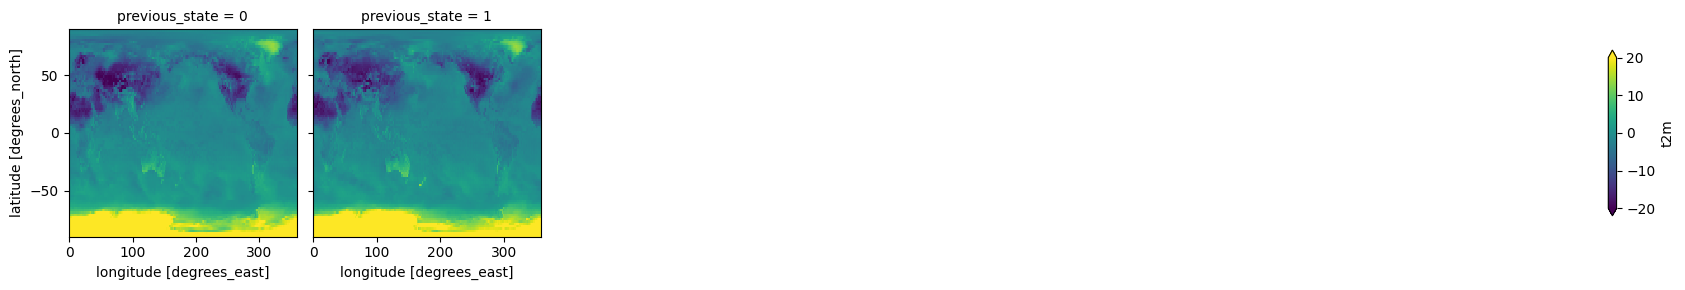

In [ ]:
ds = xr.open_dataset(data_path)
mean = ds.mean()['t2m'].values
std = ds.std()['t2m'].values
mean_field = data['t2m'].mean(dim='valid_time').values

samples = []
for i in range(shape[0]):
    samples.append(xr.Dataset({
    "t2m": (("lat", "lon"), mean + std*denoised_images[i].cpu().numpy()-mean_field)
    },
    coords={
        'lon':ds['lon'],
         'lat':ds['lat']}))

samples = [sample for sample in samples]
combined = xr.concat(samples,dim=axis_name)

combined["t2m"].plot(
    col=axis_name,
    col_wrap=6,
    cmap="viridis",
    cbar_kwargs={
        "orientation": "vertical",   # vertical colorbar at the side
        "pad": 0.05,                  # distance from the plots
        "shrink": 0.8                  # shrink length
    },
    vmin=-20,
    vmax=20
)

In [28]:
mean_field

<xarray.Dataset> Size: 67kB
Dimensions:  (lon: 180, lat: 90)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Data variables:
    t2m      (lat, lon) float32 65kB 227.8 227.8 227.8 ... 259.6 259.6 259.7

In [24]:
samples['t2m']

TypeError: list indices must be integers or slices, not str

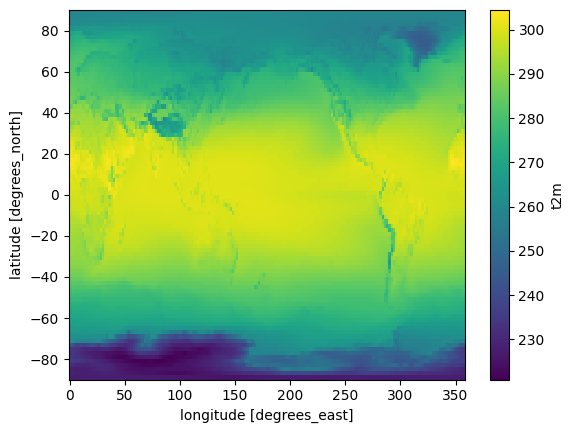

In [17]:
(combined["t2m"] - mean_field).plot(
    col=axis_name,
    col_wrap=6,
    cmap="viridis",
    cbar_kwargs={
        "orientation": "vertical",   # vertical colorbar at the side
        "pad": 0.05,                  # distance from the plots
        "shrink": 0.8                  # shrink length
    },
    vmin=-10,
    vmax=10
)

AttributeError: module 'xarray' has no attribute 'DataTree'

In [18]:
combined["t2m"] 

<xarray.DataArray 't2m' (previous_state: 2, lat: 90, lon: 180)> Size: 130kB
array([[[258.1207 , 257.77472, 258.11896, ..., 258.55008, 258.26624,
         258.26663],
        [259.12546, 258.90347, 258.81296, ..., 258.84183, 259.08453,
         258.927  ],
        [260.1812 , 259.84695, 260.22028, ..., 260.09277, 260.23157,
         260.4879 ],
        ...,
        [257.77792, 257.77472, 257.90958, ..., 257.77472, 257.77472,
         257.77472],
        [258.22623, 258.26306, 258.29263, ..., 257.93726, 257.86285,
         258.38736],
        [258.16382, 257.91904, 258.13397, ..., 258.1201 , 258.38397,
         258.05127]],

       [[258.7646 , 258.6129 , 258.66754, ..., 258.40677, 258.2968 ,
         258.54996],
        [259.18005, 259.17648, 259.10953, ..., 259.2515 , 259.29694,
         259.4633 ],
        [262.0913 , 261.47955, 261.04593, ..., 260.75314, 261.1503 ,
         261.73425],
        ...,
        [257.77472, 257.77472, 257.77472, ..., 257.80142, 257.835  ,
         257.77472],
        [258.87466, 258.85754, 258.83542, ..., 258.5347 , 258.42715,
         258.81717],
        [257.77472, 257.77472, 257.77472, ..., 257.77472, 257.77472,
         257.77472]]], shape=(2, 90, 180), dtype=float32)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: previous_state

In [6]:
data.valid_time.values

array(['2011-01-01T00:00:00.000000000', '2011-01-01T06:00:00.000000000',
       '2011-01-01T12:00:00.000000000', ...,
       '2011-12-31T06:00:00.000000000', '2011-12-31T12:00:00.000000000',
       '2011-12-31T18:00:00.000000000'],
      shape=(1460,), dtype='datetime64[ns]')

In [ ]:
import xarray as xr
import torch
import matplotlib.pyplot as plt
import torch
from models import DiT_models
from diffusion import create_diffusion
import numpy as np



data = xr.open_dataset("/p/project1/training2533/lancelin1/WeGenDiffusion/data/2011_t2m_era5_2deg.nc")


model_path = "/p/project1/training2533/lancelin1/WeGenDiffusion/results/DiT-B-2_previous_state_3/ckpt_0000080.pt"
data_path = "/p/project1/training2533/lancelin1/WeGenDiffusion/data/2011_t2m_era5_2deg.nc"
num_rollouts = 28

indices = [0, 100, 200]
num_indices = len(indices)
shape = (num_indices,1,90,180)
output_name = 'previous_state_test1'
axis_name = 'previous_state'
labels = "previous_state"
combine_imgs = False




model_state_dict = torch.load(model_path, map_location='cuda')['model']
model = DiT_models['DiT-B/2'](input_size=(90,180),num_classes=1000, labels=labels).to('cuda')
model.load_state_dict(model_state_dict,strict=True)
model.eval()

y = np.concat([np.expand_dims((data.isel(valid_time=index+1)[var].values - mean[var].values)/std[var].values,axis=0) 
                            for var in vars for index in indices])
for i in range(num_rollouts):
    print(f"Rollout {i+1} of {num_rollouts}")
    diffusion = create_diffusion(timestep_respacing="", diffusion_steps=100)
    vars = ['t2m']
    mean = data.mean()
    std = data.std()
    print(y.shape)
    y = torch.tensor(y, dtype=torch.float32, device='cuda')
    y = y.reshape(num_indices, 1, 90, 180)
    print(y.shape)

    denoised_images = diffusion.p_sample_loop(model,shape,model_kwargs=dict(y=y), progress=True)
    y = denoised_images
    # save the raw outputs since generation is expensive
    # convert to numpy array
    denoised_images = denoised_images.cpu().numpy()
    print(denoised_images)
    torch.save(denoised_images, f'samples/forecast/{output_name}_rollout_{i}.npy')
     


# denoised_images = torch.squeeze(denoised_images, 1)

Rollout 1 of 28
(3, 90, 180)
torch.Size([3, 1, 90, 180])


 26%|██▌       | 26/100 [00:12<00:34,  2.15it/s]

In [39]:
path = "/p/project1/training2533/lancelin1/WeGenDiffusion/samples/previous_state_test1_rollout_0.npy"
sample = np.load(path)
sample

NpzFile '/p/project1/training2533/lancelin1/WeGenDiffusion/samples/previous_state_test1_rollout_0.npy' with keys: previous_state_test1_rollout_0/data.pkl, previous_state_test1_rollout_0/.format_version, previous_state_test1_rollout_0/.storage_alignment, previous_state_test1_rollout_0/byteorder, previous_state_test1_rollout_0/version...